In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time
import datetime as dt
from sklearn.preprocessing import PowerTransformer,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel('global_superstore_2016.xlsx')
print(df.shape)
df.head()

(51290, 24)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980,2,0.0,62.1544,40.77,High
1,26341,IN-2014-JR162107-41675,2014-02-05,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2014-CR127307-41929,2014-10-17,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2014-KM1637548-41667,2014-01-28,2014-01-30,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2014-RH9495111-41948,2014-11-05,2014-11-06,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   Postal Code     9994 non-null   float64       
 9   City            51290 non-null  object        
 10  State           51290 non-null  object        
 11  Country         51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Market          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

In [4]:
df.shape

(51290, 24)

In [5]:
#exploring the unique values of each attribute
print("Number of transactions: ", df['Order ID'].nunique())
print("Number of products bought: ",df['Product ID'].nunique())
print("Number of customers:", df['Customer ID'].nunique() )

Number of transactions:  25728
Number of products bought:  3788
Number of customers: 17415


## RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups.

RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

RECENCY (R): Days since last purchase

FREQUENCY (F): Total number of purchases

MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

### Recency

To calculate recency, we need to choose a date point from which we evaluate how many days ago was the customer's last purchase.

In [6]:
#last order date available in our dataset
df['Order Date'].max()

Timestamp('2015-12-31 00:00:00')

The last date we have is 2011-12-09 so we will use it as reference.

In [7]:
now = dt.date(2015,12,31)
print(now)

2015-12-31


In [8]:
df['date'] = df['Order Date'].dt.date
df[['date']].head()

,date
0,2014-11-11
1,2014-02-05
2,2014-10-17
3,2014-01-28
4,2014-11-05


In [9]:
#group by customers and check last date of purshace
recency_df = df.groupby(by='Customer ID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,AA-10315102,2015-01-07
1,AA-10315120,2013-05-16
2,AA-10315139,2015-08-04
3,AA-103151402,2015-06-30
4,AA-103151404,2013-10-04


In [10]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,AA-10315102,2015-01-07,358
1,AA-10315120,2013-05-16,959
2,AA-10315139,2015-08-04,149
3,AA-103151402,2015-06-30,184
4,AA-103151404,2013-10-04,818


Now we have the recency attribute created. e.g: Customer with ID = AA-10315102 did his/her last purshace 358 days ago.

In [11]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

### Frequency
Frequency helps us to know how many times a customer purchased from us. To do that we need to check how many invoices are registered by the same customer.

In [12]:
df_copy = df.copy()
df_copy.drop_duplicates(subset=['Order ID', 'Customer ID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = df_copy.groupby(by=['Customer ID'], as_index=False)['Order ID'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,AA-10315102,2
1,AA-10315120,1
2,AA-10315139,4
3,AA-103151402,2
4,AA-103151404,2


### Monetary
Monetary attribute answers the question: How much money did the customer spent over time?

In [13]:
monetary_df = df.groupby(by='Customer ID',as_index=False).agg({'Sales': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,AA-10315102,544.656
1,AA-10315120,2713.410
2,AA-10315139,2955.798
3,AA-103151402,4780.552
4,AA-103151404,753.508


## Create RFM Table

In [14]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,AA-10315102,358,2
1,AA-10315120,959,1
2,AA-10315139,149,4
3,AA-103151402,184,2
4,AA-103151404,818,2


In [15]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
AA-10315102,358,2,544.656
AA-10315120,959,1,2713.410
AA-10315139,149,4,2955.798
AA-103151402,184,2,4780.552
AA-103151404,818,2,753.508


Customer with ID = AA-10315102 has recency: 358 days, frequency:2, and monetary: $544.656.

### RFM Table Correctness verification

In [16]:
df[df['Customer ID']=='AA-10315120']

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,date
1403,16421,ES-2013-AA10315120-41410,2013-05-16,2013-05-21,Standard Class,AA-10315120,Alex Avila,Consumer,NaN,Parla,...,Furniture,Bookcases,"Sauder Library with Doors, Traditional",2713.41,7,0.0,27.09,167.35,Medium,2013-05-16


In [17]:
(now - dt.date(2013,5,16)).days == 959

True

As we can see our RFM table is correct. The 2nd customer bought only once, and only and that too 959 days back.

## Customer Segments with RFM Model
Before moving to customer segments, Let's see the application of Pareto Principle – commonly referred to as the 80-20 rule on our dataset by applying it to our RFM variables.

Pareto’s rule says 80% of the results come from 20% of the causes.

Similarly, 20% customers contribute to 80% of your total revenue. Let's verify that because that will help us know which customers to focus on when marketing new products.

In [18]:
#get the 80% of the revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  10114001.53


In [19]:
customers_rank = rfm_df.copy()
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
AA-10315102,358,2,544.656,6621.0
AA-10315120,959,1,2713.410,908.0
AA-10315139,149,4,2955.798,754.0
AA-103151402,184,2,4780.552,200.0
AA-103151404,818,2,753.508,5171.0


### Top Customers

In [20]:
customers_rank.sort_values('Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
SM-203201408,79,2,23669.196,1.0
TC-209801402,454,2,18437.138,2.0
RB-193601404,282,2,14345.276,3.0
TA-213851406,69,2,13723.498,4.0
AB-101051402,149,5,12181.594,5.0
...,...,...,...,...
CC-123701402,54,1,1.248,17411.0
KN-164501408,1111,1,1.167,17412.0
TS-213401402,1026,1,1.112,17413.0


In [21]:
#get top 20% of the customers
top_20_cutoff = 17415 *20 /100
top_20_cutoff

3483.0

In [22]:
#sum the monetary values over the customer with rank <=3483
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 3483]['Monetary'].sum()
revenueByTop20

8205046.77592

In our case, the 80% of total revenue is not achieved by the 20% of TOP customers but approximately, it does, because they are less than our 20% TOP customers who achieve it. It would be interesting to study this group of customers because they are those who make our most revenue.

### Applying RFM score formula
The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 555 possible combinations. So, we will use quartiles.

In [23]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,148.0,1.0,98.345
0.50,421.0,1.0,326.994
0.75,803.0,2.0,912.854


In [24]:
quantiles.to_dict()

{'Recency': {0.25: 148.0, 0.5: 421.0, 0.75: 803.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 98.345, 0.5: 326.994, 0.75: 912.854}}

### Creation of RFM segmentation table
We will create two segmentation classes since, high recency in not favoulable, while high frequency and monetary value is good.

In [25]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [26]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [27]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
AA-10315102,358,2,544.656,3,3,3
AA-10315120,959,1,2713.410,1,1,4
AA-10315139,149,4,2955.798,3,4,4
AA-103151402,184,2,4780.552,3,3,4
AA-103151404,818,2,753.508,1,3,3


In [28]:
rfm_segmentation['RFMGroup'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMGroup
CustomerID,,,,,,,
AA-10315102,358,2,544.656,3,3,3,333
AA-10315120,959,1,2713.410,1,1,4,114
AA-10315139,149,4,2955.798,3,4,4,344
AA-103151402,184,2,4780.552,3,3,4,334
AA-103151404,818,2,753.508,1,3,3,133


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

Let's see who are our best customers.

Now that we have the score of each customer, we can represent our customer segmentation.
First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [60]:
rfm_segmentation['RFMScore'] = rfm_segmentation['R_Quartile']*0.15+rfm_segmentation['F_Quartile']*0.30+ rfm_segmentation['M_Quartile']*0.55
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMGroup,RFMScore
CustomerID,,,,,,,,
AA-10315102,358,2,544.656,3,3,3,333,3.00
AA-10315120,959,1,2713.410,1,1,4,114,2.65
AA-10315139,149,4,2955.798,3,4,4,344,3.85
AA-103151402,184,2,4780.552,3,3,4,334,3.55
AA-103151404,818,2,753.508,1,3,3,133,2.70


In [63]:
rfm_segmentation['RFMScore'].describe()

count    17415.000000
mean         2.271573
std          0.876556
min          1.000000
25%          1.550000
50%          2.250000
75%          2.950000
max          4.000000
Name: RFMScore, dtype: float64

In [64]:
rfm_segmentation['Customer Segment']=np.where(rfm_segmentation['RFMScore'] > 2.95 ,"High Value Customer",(np.where(rfm_segmentation['RFMScore'] < 2.24 , "Low value Customer" ,"Medium Value Customer")))
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMGroup,RFMScore,Customer Segment
CustomerID,,,,,,,,,
AA-10315102,358,2,544.656,3,3,3,333,3.00,High Value Customer
AA-10315120,959,1,2713.410,1,1,4,114,2.65,Medium Value Customer
AA-10315139,149,4,2955.798,3,4,4,344,3.85,High Value Customer
AA-103151402,184,2,4780.552,3,3,4,334,3.55,High Value Customer
AA-103151404,818,2,753.508,1,3,3,133,2.70,Medium Value Customer


In [88]:
rfm_segmentation.drop('RFMGroup',axis=1).head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Customer Segment
CustomerID,,,,,,,,
AA-10315102,358,2,544.656,3,3,3,3.00,High Value Customer
AA-10315120,959,1,2713.410,1,1,4,2.65,Medium Value Customer
AA-10315139,149,4,2955.798,3,4,4,3.85,High Value Customer
AA-103151402,184,2,4780.552,3,3,4,3.55,High Value Customer
AA-103151404,818,2,753.508,1,3,3,2.70,Medium Value Customer


<Figure size 720x432 with 0 Axes>

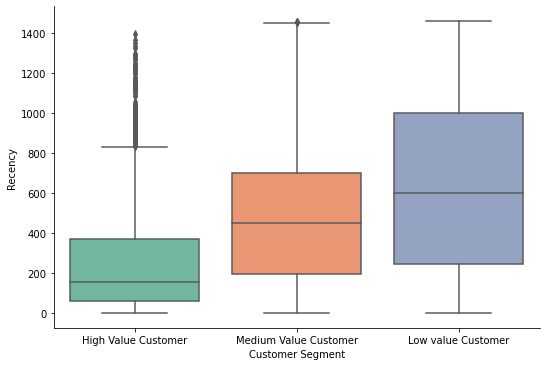

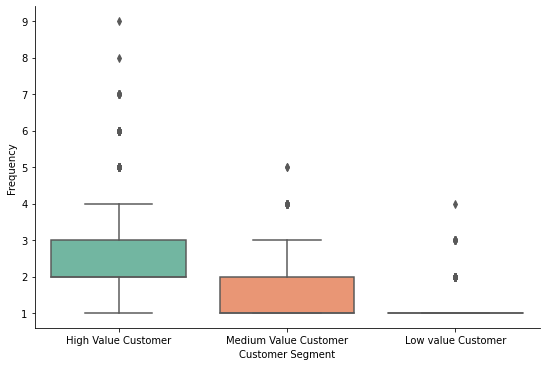

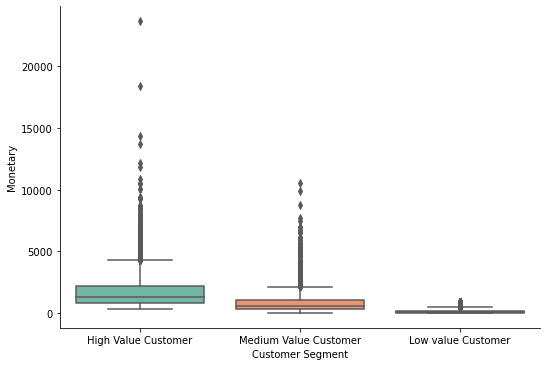

In [89]:
plt.figure(figsize=(10,6))
for i in rfm_segmentation.drop(['R_Quartile','F_Quartile','M_Quartile','RFMGroup','RFMScore','Customer Segment'],axis=1).columns:
    sns.catplot(x='Customer Segment',y=i,data=rfm_segmentation,palette="Set2",kind='box',aspect=1.5)
    plt.show()

In [29]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm_segmentation['RFMScore'] = rfm_segmentation[['R_Quartile', 'F_Quartile', 'M_Quartile']].sum(axis = 1)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMGroup,RFMScore
CustomerID,,,,,,,,
AA-10315102,358,2,544.656,3,3,3,333,9
AA-10315120,959,1,2713.410,1,1,4,114,6
AA-10315139,149,4,2955.798,3,4,4,344,11
AA-103151402,184,2,4780.552,3,3,4,334,10
AA-103151404,818,2,753.508,1,3,3,133,7


In [30]:
rfm_segmentation['RFMScore'].unique()

array([ 9,  6, 11, 10,  7,  3,  8,  4,  5, 12], dtype=int64)

In [31]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Bronze', 'Silver', 'Gold', 'Diamond']
Score_cuts = pd.qcut(rfm_segmentation.RFMScore, q = 4, labels = Loyalty_Level)
rfm_segmentation['RFM_Loyalty_Level'] = Score_cuts.values
rfm_segmentation.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMGroup,RFMScore,RFM_Loyalty_Level
0,AA-10315102,358,2,544.656,3,3,3,333,9,Gold
1,AA-10315120,959,1,2713.410,1,1,4,114,6,Silver
2,AA-10315139,149,4,2955.798,3,4,4,344,11,Diamond
3,AA-103151402,184,2,4780.552,3,3,4,334,10,Diamond
4,AA-103151404,818,2,753.508,1,3,3,133,7,Gold


In [32]:
rfm_segmentation[rfm_segmentation['RFMGroup']=='444'].sort_values(by='Monetary').head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMGroup,RFMScore,RFM_Loyalty_Level
CustomerID,,,,,,,,,
CS-124001404,106,5,913.26400,4,4,4,444,12,Diamond
KA-165251406,36,3,914.57800,4,4,4,444,12,Diamond
TH-211151406,58,3,915.58400,4,4,4,444,12,Diamond
KB-1660092,86,3,917.30400,4,4,4,444,12,Diamond
AS-1004559,76,3,921.19740,4,4,4,444,12,Diamond
BG-117401404,57,3,925.34800,4,4,4,444,12,Diamond
NG-1835545,110,3,926.17500,4,4,4,444,12,Diamond
TT-2146018,61,3,927.60864,4,4,4,444,12,Diamond
JE-1561027,96,3,932.73000,4,4,4,444,12,Diamond


We can find here a suggestion of key segments and then we can decide which segment to consider for further study.

Note: the suggested link use the opposite valuation: 1 as highest/best score and 4 is the lowest.

How many customers do we have in each segment?

In [33]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMGroup']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMGroup']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMGroup']=='144']))
print('Lost Low Spenders: ',len(rfm_segmentation[rfm_segmentation['RFMGroup']=='111']))

Best Customers:  672
Loyal Customers:  1969
Big Spenders:  4354
Almost Lost:  193
Lost Customers:  32
Lost Low Spenders:  1336


Now that we knew our customers segments we can choose how to target or deal with each segment.

For example:

Best Customers - Champions: Reward them. They can be early adopters to new products. Suggest them "Refer a friend".

At Risk: Send them personalized emails to encourage them to shop.

Conclusion - perspective from this level of customer segmentation
To gain even further insight into customer behavior, we can dig deeper in the relationship between RFM variables.

RFM model can be used in conjunction with certain predictive models like k-means clustering, Logistic Regression and Recommendation to produce better informative results on customer behavior.

We will go for k-means since it has been widely used for Market Segmentation and it offers the advantage of being simple to implement.

## Applying K-means clustering on RFM variables

In [34]:
#Preprocess Data
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary,RFMGroup,RFM_Loyalty_Level
CustomerID,,,,,
AA-10315102,358,2,544.656,333,Gold
AA-10315120,959,1,2713.410,114,Silver
AA-10315139,149,4,2955.798,344,Diamond
AA-103151402,184,2,4780.552,334,Diamond
AA-103151404,818,2,753.508,133,Gold


In [35]:
features = rfm_data.columns

#### Visualize feature distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the three features present in the RFM data.

We can notice that we have a skewed distribution of the 3 variables and there exist outliers.

This indicates how normalization is required to make the data features normally distributed as clustering algorithms require them to be normally distributed.

In [35]:
rfm_data=rfm_data[['Recency','Frequency','Monetary']]

In [36]:
features = rfm_data.columns

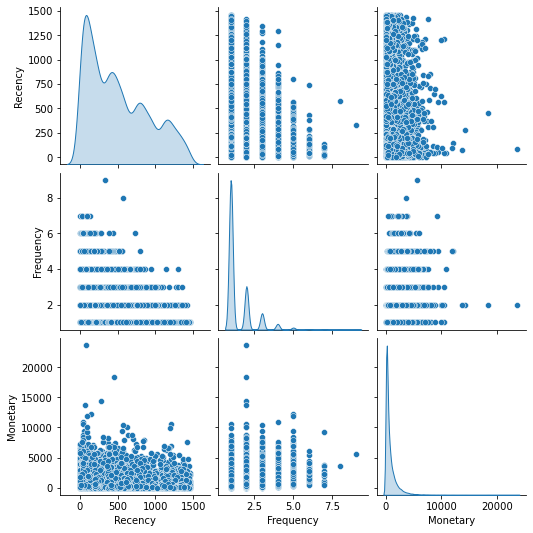

In [37]:
#checking the distribution
sns.pairplot(rfm_data,diag_kind='kde')

In [38]:
#Five Point summary
rfm_data.describe()

,Recency,Frequency,Monetary
count,17415.000000,17415.000000,17415.000000
mean,507.087913,1.477979,725.954746
std,400.619145,0.852081,1064.751183
min,0.000000,1.000000,0.556000
25%,148.000000,1.000000,98.345000
50%,421.000000,1.000000,326.994000
75%,803.000000,2.000000,912.854000
max,1460.000000,9.000000,23669.196000


In [39]:
rfm_data.skew()

Recency      0.601705
Frequency    2.176645
Monetary     3.865886
dtype: float64

Since K-means is an distance based and features in our RFM table are skewed, we need to Scale and Transform the data

In [40]:
#Power Transformer will scale as well as tranform the data, so we dont need multiple algorithms.
pt = PowerTransformer()
rfm_data = pd.DataFrame(pt.fit_transform(rfm_data))
rfm_data.columns = features
rfm_data.head()

,Recency,Frequency,Monetary
0,-0.096138,1.361892,0.369660
1,1.080213,-0.671052,1.588263
2,-0.811711,1.730292,1.658506
3,-0.662093,1.361892,2.063863
4,0.857132,1.361892,0.601308


Recency     -0.182177
Frequency    0.836413
Monetary    -0.030526
dtype: float64


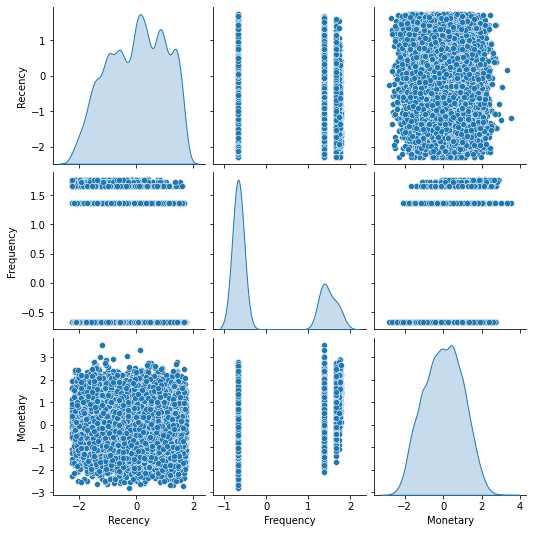

In [41]:
print(rfm_data.skew())
sns.pairplot(rfm_data,diag_kind='kde')

Data is Scaled and Skewness has come in the acceptable range of -1.5 to 1.5, after PowerTransformation

<function matplotlib.pyplot.show(close=None, block=None)>

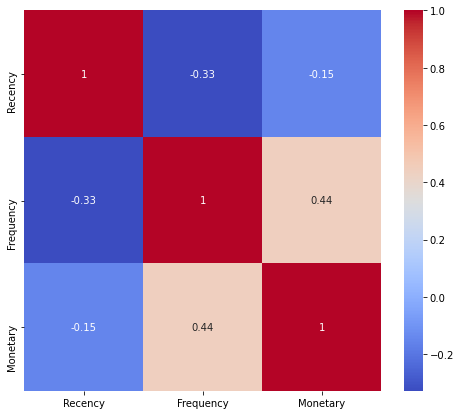

In [42]:
plt.figure(figsize=(8,7))
sns.heatmap(rfm_data.corr(),annot=True,cmap='coolwarm')
plt.show

On one hand, we have a negative correlation between:

-Recency and Frequency

-Recency and Monetary

On the other hand, the correlation between Monetary and Frequency is positive comparing to negative ones but still not that strong.

### K-means Implementation
A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The elbow method can be used to determine the number of clusters as well.

Note: K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called k-means++.

In [43]:
X=rfm_data

In [44]:
from sklearn.cluster import KMeans
# Let us check optimal number of clusters-
cluster_range = range( 1, 10)
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(X)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:10]

,num_clusters,cluster_errors
0,1,52245.000000
1,2,29925.462659
2,3,21685.458599
3,4,16605.141965
4,5,13639.074232
5,6,11450.010328
6,7,9975.101637
7,8,8867.532590
8,9,7909.673882


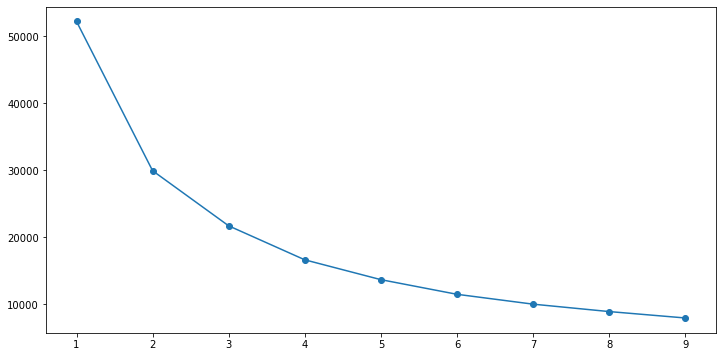

In [45]:
# Elbow plot visualisation to find out optimal number of clusters

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [46]:
# Number of clusters=2 as we can see a bent in above elpow plot at 2
kmeans = KMeans(n_clusters=2,n_init = 100,init='k-means++',random_state=0)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print(centroids) # From sci-kit learn

Centroid values
[[ 0.22467403 -0.66747734 -0.30174553]
 [-0.49049656  1.45720148  0.65875499]]


In [47]:
colnames = ["Monetary", "Recency","Frequency"]
prediction= kmeans.predict(X)
X_df = pd.DataFrame(X, columns= colnames)
X_df["group"] = prediction
X_df.head()

,Monetary,Recency,Frequency,group
0,0.369660,-0.096138,1.361892,1
1,1.588263,1.080213,-0.671052,0
2,1.658506,-0.811711,1.730292,1
3,2.063863,-0.662093,1.361892,1
4,0.601308,0.857132,1.361892,1


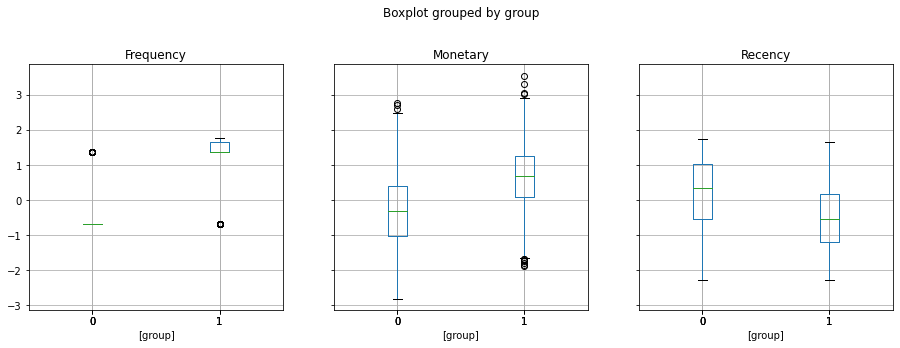

In [48]:
X_df.boxplot(by = 'group',layout=(2,3), figsize=(15, 10))
plt.show()

Customers segmented in group-1 are loyal and comparitively big spenders than those who are segmented in to group-0

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.4379570137599265


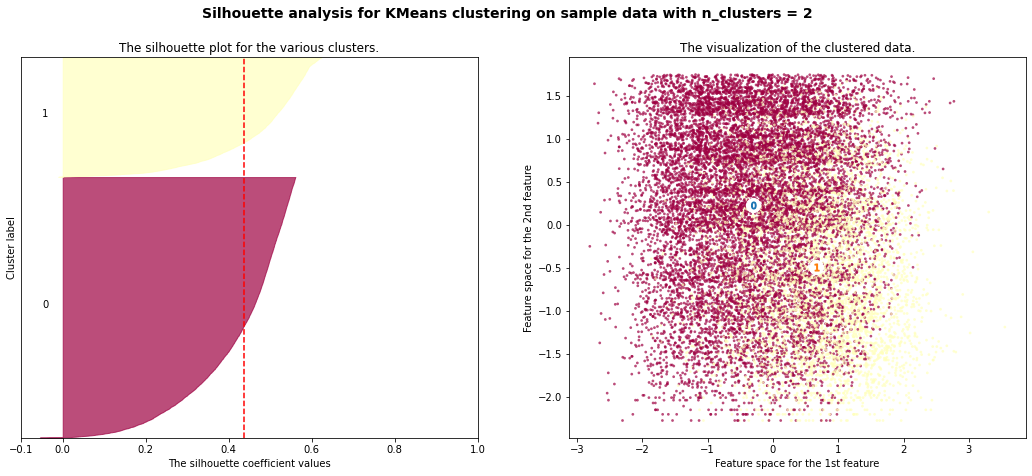

For n_clusters = 3 The average silhouette_score is : 0.38062216228730716


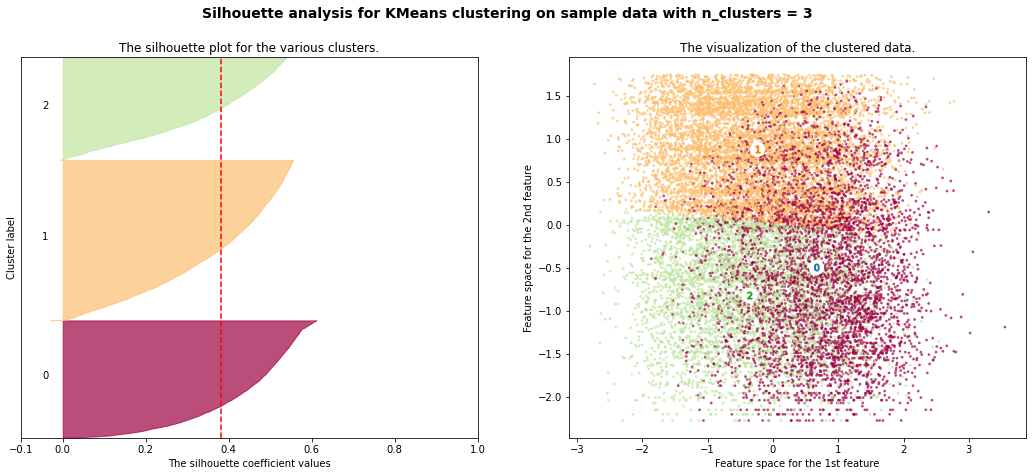

For n_clusters = 4 The average silhouette_score is : 0.3828598776278175


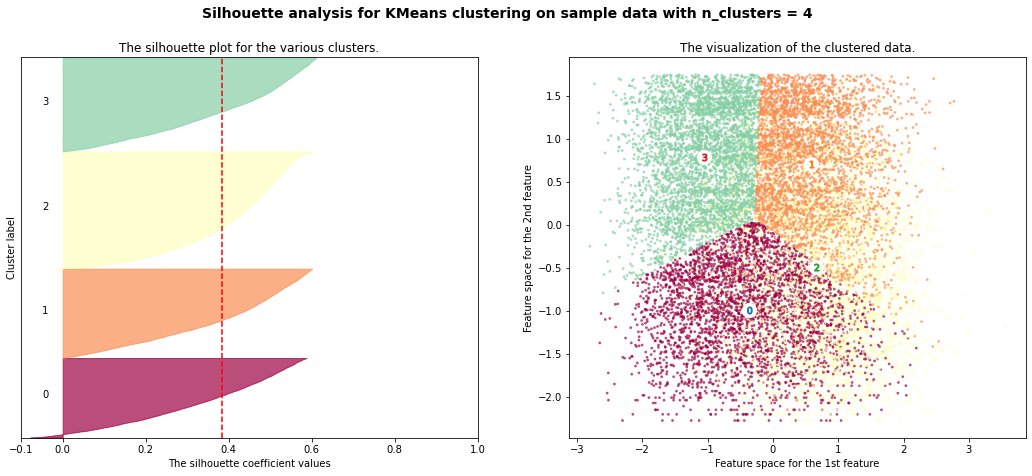

For n_clusters = 5 The average silhouette_score is : 0.36486575587669684


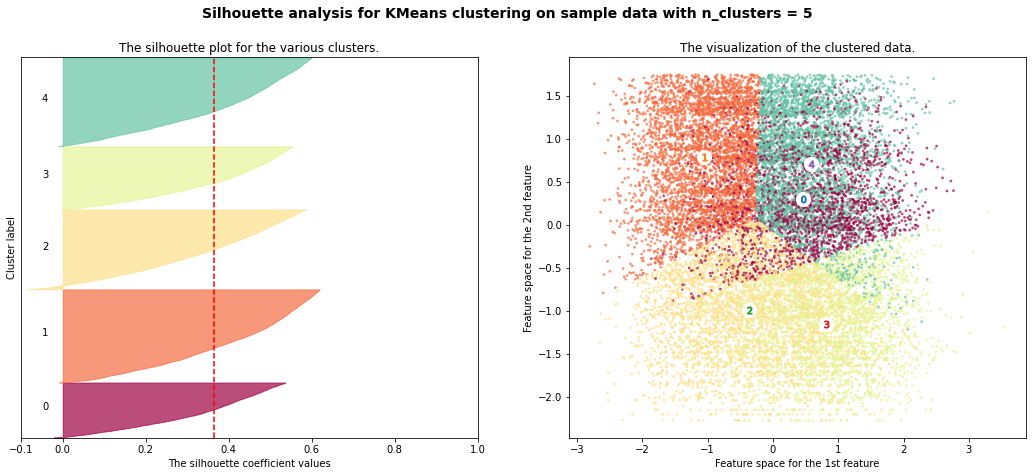

For n_clusters = 6 The average silhouette_score is : 0.3563889613232768


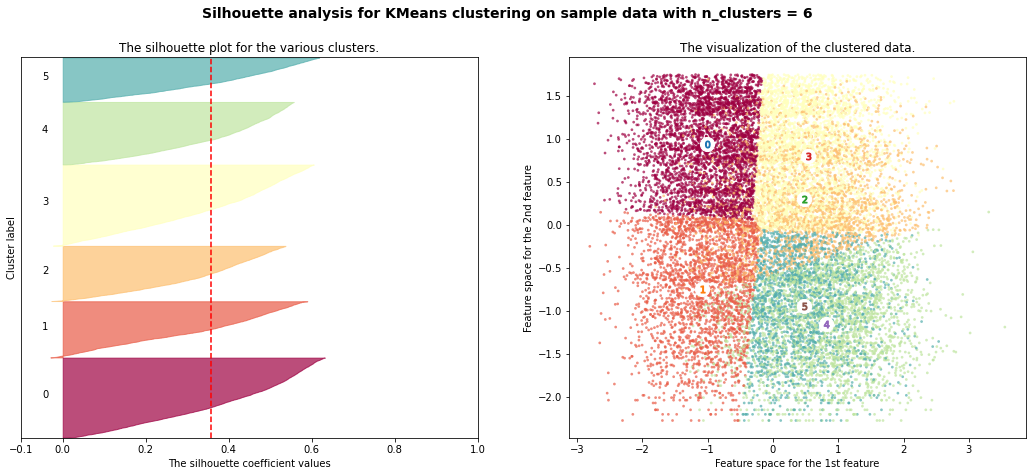

For n_clusters = 7 The average silhouette_score is : 0.3564273918938282


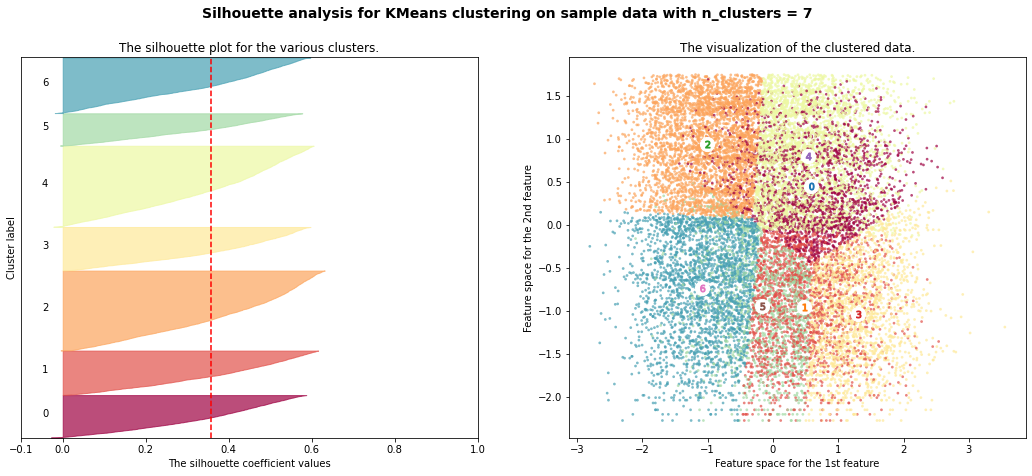

For n_clusters = 8 The average silhouette_score is : 0.33808016167253657


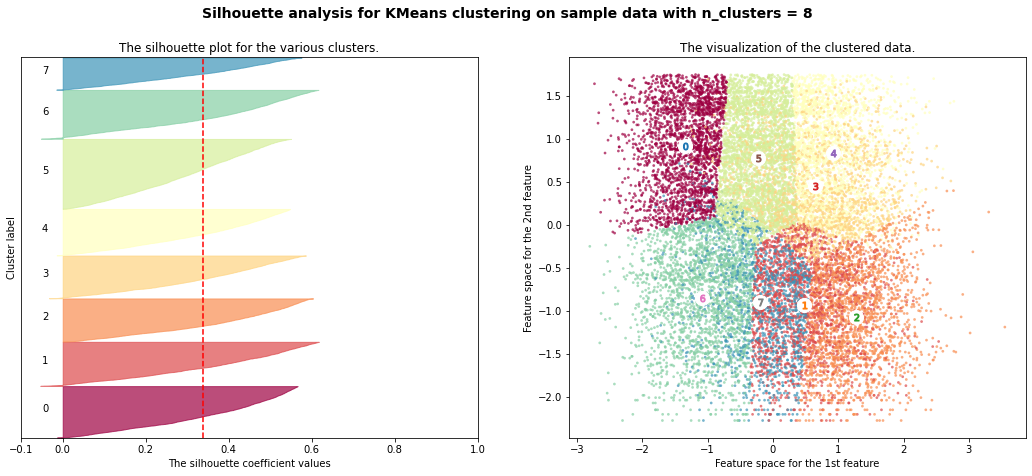

For n_clusters = 9 The average silhouette_score is : 0.3492211240836837


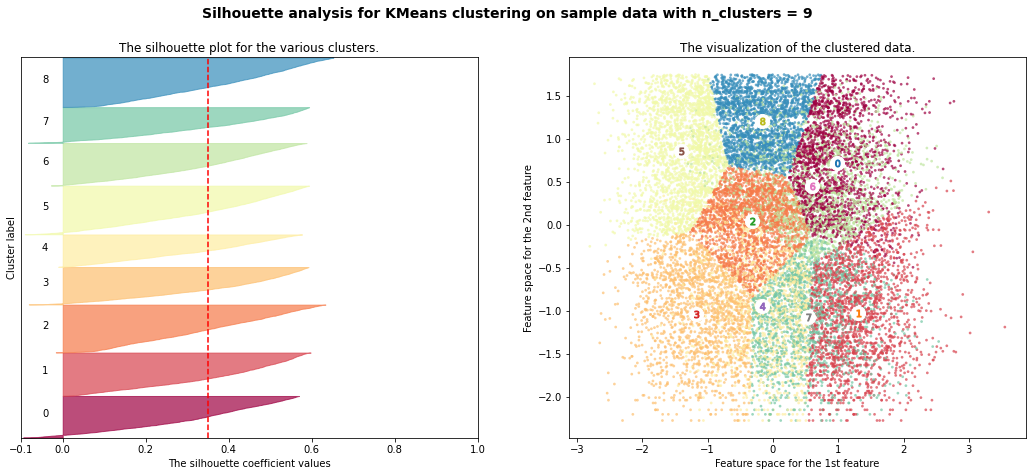

For n_clusters = 10 The average silhouette_score is : 0.3474613542773037


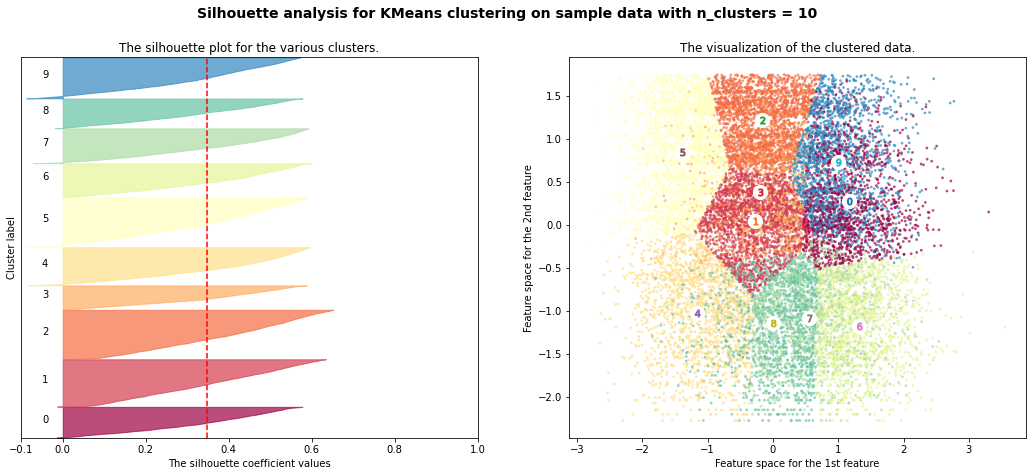

In [49]:
from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=X_df.drop('group',axis=1).values
y=X_df['group'].values

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,n_init = 100,init='k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

2 clusters are having highest Silhouette Score, which means the quality of clusters in case of 2 clusters is the better.

In [50]:
cluster_df=rfm_segmentation.copy()
cluster_df['group']=X_df['group'].values
cluster_df.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMGroup,RFMScore,RFM_Loyalty_Level,group
CustomerID,,,,,,,,,,
AA-10315102,358,2,544.656,3,3,3,333,9,Gold,1
AA-10315120,959,1,2713.410,1,1,4,114,6,Silver,0
AA-10315139,149,4,2955.798,3,4,4,344,11,Diamond,1
AA-103151402,184,2,4780.552,3,3,4,334,10,Diamond,1
AA-103151404,818,2,753.508,1,3,3,133,7,Gold,1


All customers are now labelled in the thier respective segments/groups

In [51]:
cluster_df['group'].value_counts()

0    11944
1     5471
Name: group, dtype: int64

In [53]:
cluster_df=cluster_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
cluster_df['group'].replace({0:'Regular',1:'Premium'},inplace=True)
cluster_df.head()

,Recency,Frequency,Monetary,RFMGroup,RFM_Loyalty_Level,group
CustomerID,,,,,,
AA-10315102,358,2,544.656,333,Gold,Premium
AA-10315120,959,1,2713.410,114,Silver,Regular
AA-10315139,149,4,2955.798,344,Diamond,Premium
AA-103151402,184,2,4780.552,334,Diamond,Premium
AA-103151404,818,2,753.508,133,Gold,Premium


In [54]:
cluster_df.drop(['RFMGroup','RFM_Loyalty_Level'],axis=1,inplace=True)

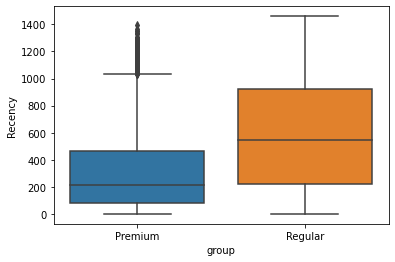

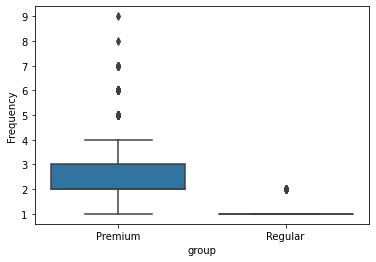

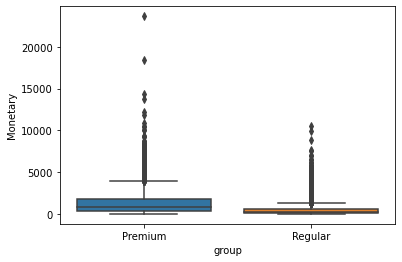

In [65]:
for i in cluster_df.drop('group',axis=1).columns:
    sns.boxplot(x='group',y=i,data=cluster_df)
    plt.show()

In [71]:
cluster_df.groupby('group').describe()

Recency                                                             \
           count        mean         std  min     25%    50%    75%     max   
group                                                                         
Premium   5471.0  309.247670  285.399043  0.0   80.00  214.0  461.5  1394.0   
Regular  11944.0  597.709478  412.999422  0.0  218.75  543.0  925.0  1460.0   

        Frequency            ...           Monetary                            \
            count      mean  ...  75%  max    count         mean          std   
group                        ...                                                
Premium    5471.0  2.517638  ...  3.0  9.0   5471.0  1319.728618  1435.681721   
Regular   11944.0  1.001758  ...  1.0  2.0  11944.0   453.974099   688.116687   

                                                           
            min        25%     50%         75%        max  
group                                                      
Premium  11.646  358.70812  857.42  1778.53550  23669.196  
Regular   0.556   60.60000  193.68   561.23625  10539.896  

[2 rows x 24 columns]